In [1]:
import sys
sys.path.append('..') 
import os

import psycopg2
import pandas as pd
import numpy as np
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta

# Main

## Data Loading

In [2]:
# """DataLoad"""
# from src.utils.config import get_config
# from src.db_ops.db_ops import PosgreOps

# # Load Config
# config = get_config()
# # Initialize database operator, this case posgre operator
# pgops = PosgreOps(config=config)
# ### Define the required parameters to load the data ###
# # -------------------------------------------------------- #
# months = 84
# table_name = "daas.epdk_petrol_province"
# # -------------------------------------------------------- #
# # Fetch data from database
# epdk_petrol_province_data = pgops.get_monthly_data(table_name=table_name,
#                                                 today=date.today(), months=months)
# # Close the connection after obtaining the data
# pgops.shutdown()

In [3]:
# # Investigate Results
# print(epdk_petrol_province_data.shape)
# print(epdk_petrol_province_data.province.nunique())
# print(epdk_petrol_province_data.date.min())

In [4]:
# epdk_petrol_province_data.date.dtypes

In [5]:
# Load Raw data
epdk_petrol_province_data = pd.read_csv('data/daas_raw_data.csv', index_col=[0])
epdk_petrol_province_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5904 entries, 0 to 5903
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   date            5904 non-null   object 
 1   province        5904 non-null   object 
 2   gasolene_types  5904 non-null   float64
 3   diesel_types    5904 non-null   float64
 4   fuel_oil_types  5890 non-null   float64
 5   aviation_fuels  5875 non-null   float64
 6   marine_fuels    5826 non-null   float64
 7   paraffin_oil    5838 non-null   float64
 8   other_types     5824 non-null   float64
 9   total           5904 non-null   float64
 10  percentage      5904 non-null   float64
dtypes: float64(9), object(2)
memory usage: 553.5+ KB


## Preprocessing

In [6]:
"""Preprocessing"""
from src.preprocessing.preprocess import PreprocessData

# Initialize preprocess object
prep = PreprocessData(data=epdk_petrol_province_data)
### Define parameters to preprocess ###
# -------------------------------------------------------- #
target_col_list = ["date","province","diesel_types"]
row_drop_dict = {"province": "Toplam"} 
# format_date_flag = True # True by default
col_rename_dict = {"diesel_types":"current_month_consumption"}
anomaly_col = "current_month_consumption" 
# -------------------------------------------------------- #
# Preprocess data with given parameters
preprocessed_df = prep.preprocess_data(target_col_list=target_col_list,
                                 row_drop_dict=row_drop_dict,
                                 col_rename_dict=col_rename_dict,
                                 anomaly_col=anomaly_col)


Missing Dates are:  [numpy.datetime64('2021-10-01T00:00:00.000000000')]


In [7]:
# Investigate results
print(preprocessed_df.shape)
print(preprocessed_df.province.nunique())
print(preprocessed_df.date.min())

(5913, 3)
81
2016-01-01 00:00:00


In [8]:
preprocessed_df.tail()

,date,province,current_month_consumption
5834,2022-01-01,ÇORUM,7030.322
5849,2022-01-01,İSTANBUL,312346.398
5851,2022-01-01,İZMİR,93476.673
5894,2022-01-01,ŞANLIURFA,19790.450
5882,2022-01-01,ŞIRNAK,5701.813


In [9]:
# Control whether the missing values at 2021-10-01 are filled 
preprocessed_df.query(f"date=='{date(2021,10,1)}'").sort_values(by="current_month_consumption").tail()

,date,province,current_month_consumption
5669,2021-10-01,KONYA,76596.319000
5607,2021-10-01,BURSA,86588.115500
5608,2021-10-01,İZMİR,110690.847500
5617,2021-10-01,ANKARA,186113.792667
5606,2021-10-01,İSTANBUL,323780.346000


In [10]:
# # Save preprocessed data
# preprocessed_df.to_csv("data/preprocessed_df.csv")
# # Load preprocessed data
# parse_dates = ["date"]
# preprocessed_df = pd.read_csv('data/preprocessed_df.csv', index_col=[0], parse_dates=parse_dates)
# preprocessed_df.info()

## Plotting

Shape of dataframe is :  (73, 3)


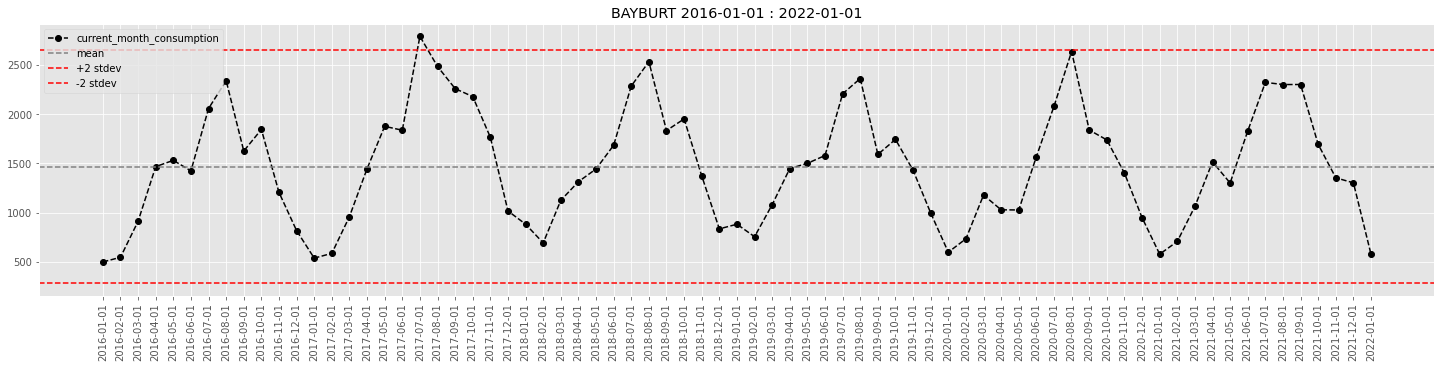

In [11]:
"""Plotting"""
from src.utils.plotting import plot_province

plot_province(df=preprocessed_df, col_x="date", col_y="current_month_consumption", province="BAYBURT", stdev=2)

## Feature Engineering

In [12]:
"""FeatureEngineering"""
from src.feature_engineering.feat_eng import FeatureEngineering

# Initialize feature engineering object
feng = FeatureEngineering(data=preprocessed_df)
# Apply feature engineering to the preprocessed data
feature_engineered_df = feng.feature_engineering()

Index(['date', 'province', 'current_month_consumption'], dtype='object')


c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\Users\PC\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros 

add_ARIMA_predictions_ done
Index(['date', 'province', 'current_month_consumption', 'ARIMA_prediction'], dtype='object')
add_auto_reg_features done
Index(['date', 'province', 'current_month_consumption', 'ARIMA_prediction',
       'last_year_same_month_consumption', 'last_year_total_consumption',
       'rolling_mean_2', 'rolling_mean_3', 'rolling_mean_4', 'rolling_mean_5',
       'rolling_mean_6', 'Lag1_monthly_share', 'Lag2_monthly_share',
       'Lag3_monthly_share', 'Lag4_monthly_share', 'Lag5_monthly_share',
       'Lag6_monthly_share', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6',
       'quarter'],
      dtype='object')
add_covid done
Index(['date', 'province', 'current_month_consumption', 'ARIMA_prediction',
       'last_year_same_month_consumption', 'last_year_total_consumption',
       'rolling_mean_2', 'rolling_mean_3', 'rolling_mean_4', 'rolling_mean_5',
       'rolling_mean_6', 'Lag1_monthly_share', 'Lag2_monthly_share',
       'Lag3_monthly_share', 'Lag4_monthly_share',

01:56:19 - cmdstanpy - INFO - Chain [1] start processing


demographics done
Index(['date', 'province', 'current_month_consumption', 'ARIMA_prediction',
       'last_year_same_month_consumption', 'last_year_total_consumption',
       'rolling_mean_2', 'rolling_mean_3', 'rolling_mean_4', 'rolling_mean_5',
       'rolling_mean_6', 'Lag1_monthly_share', 'Lag2_monthly_share',
       'Lag3_monthly_share', 'Lag4_monthly_share', 'Lag5_monthly_share',
       'Lag6_monthly_share', 'Lag1', 'Lag2', 'Lag3', 'Lag4', 'Lag5', 'Lag6',
       'quarter', 'covid', 'school_holiday', 'population'],
      dtype='object')


01:56:19 - cmdstanpy - INFO - Chain [1] done processing
01:56:20 - cmdstanpy - INFO - Chain [1] start processing
01:56:20 - cmdstanpy - INFO - Chain [1] done processing
01:56:20 - cmdstanpy - INFO - Chain [1] start processing
01:56:21 - cmdstanpy - INFO - Chain [1] done processing
01:56:21 - cmdstanpy - INFO - Chain [1] start processing
01:56:22 - cmdstanpy - INFO - Chain [1] done processing
01:56:22 - cmdstanpy - INFO - Chain [1] start processing
01:56:23 - cmdstanpy - INFO - Chain [1] done processing
01:56:23 - cmdstanpy - INFO - Chain [1] start processing
01:56:23 - cmdstanpy - INFO - Chain [1] done processing
01:56:24 - cmdstanpy - INFO - Chain [1] start processing
01:56:24 - cmdstanpy - INFO - Chain [1] done processing
01:56:24 - cmdstanpy - INFO - Chain [1] start processing
01:56:25 - cmdstanpy - INFO - Chain [1] done processing
01:56:25 - cmdstanpy - INFO - Chain [1] start processing
01:56:25 - cmdstanpy - INFO - Chain [1] done processing
01:56:26 - cmdstanpy - INFO - Chain [1] 

Index(['date', 'province', 'current_month_consumption', 'trend', 'yhat_lower',
       'yhat_upper', 'yhat'],
      dtype='object')
add_PROPHET_predictions_ done


In [13]:
feature_engineered_df.head()

,date,province,current_month_consumption,ARIMA_prediction,last_year_same_month_consumption,last_year_total_consumption,rolling_mean_2,rolling_mean_3,rolling_mean_4,rolling_mean_5,...,Lag5,Lag6,quarter,covid,school_holiday,population,trend,yhat_lower,yhat_upper,yhat
18,2017-07-01,ADANA,52226.264,50527.062674,45859.035,543580.982,48038.0960,45812.011000,44603.95700,43236.7850,...,37768.097,38776.434,3,0,31,2216475.0,46307.384134,43856.598733,55977.812246,49834.030167
19,2017-08-01,ADANA,54431.449,52065.669733,51812.765,549948.211,51686.7330,49434.152000,47415.57425,46128.4184,...,40979.795,37768.097,3,0,31,2216475.0,46377.532885,46662.019810,58058.859202,52579.093180
20,2017-09-01,ADANA,50643.323,54207.855373,47489.011,552566.895,53328.8565,52601.638333,50683.47625,48818.7492,...,41359.841,40979.795,3,0,22,2216475.0,46447.681636,44711.856770,56488.071910,50670.870798
21,2017-10-01,ADANA,54644.758,50980.212723,49816.834,555721.207,52537.3860,52433.678667,52112.05950,50675.4456,...,44928.990,41359.841,4,0,9,2216475.0,46515.567525,45224.229398,56672.119647,51105.664060
22,2017-11-01,ADANA,51195.357,54298.415896,48657.084,560549.131,52644.0405,53239.843333,52986.44850,52618.5992,...,51147.202,44928.990,4,0,8,2216475.0,46585.716277,42242.246749,53843.840069,48094.440606


In [14]:
print(feature_engineered_df.shape)
feature_engineered_df.query("current_month_consumption%1==0")

(4455, 31)


,date,province,current_month_consumption,ARIMA_prediction,last_year_same_month_consumption,last_year_total_consumption,rolling_mean_2,rolling_mean_3,rolling_mean_4,rolling_mean_5,...,Lag5,Lag6,quarter,covid,school_holiday,population,trend,yhat_lower,yhat_upper,yhat
617,2018-10-01,ARTVİN,5115.0,4793.323548,5492.85,56028.585,5108.402,5102.234333,4928.80775,5014.3880,...,5356.709,4898.667,4,0,9,174010.0,4675.068692,4823.674908,6070.903801,5451.085085
2612,2020-10-01,IĞDIR,7641.0,3217.088422,2838.76,33596.568,3535.211,3553.936333,3383.62075,3227.9508,...,2605.271,2448.283,4,1,10,201314.0,2698.905093,3302.360533,5040.191628,4181.539923


In [15]:
# feature_engineered_df.query("province == 'ARTVİN'")

Shape of dataframe is :  (55, 31)


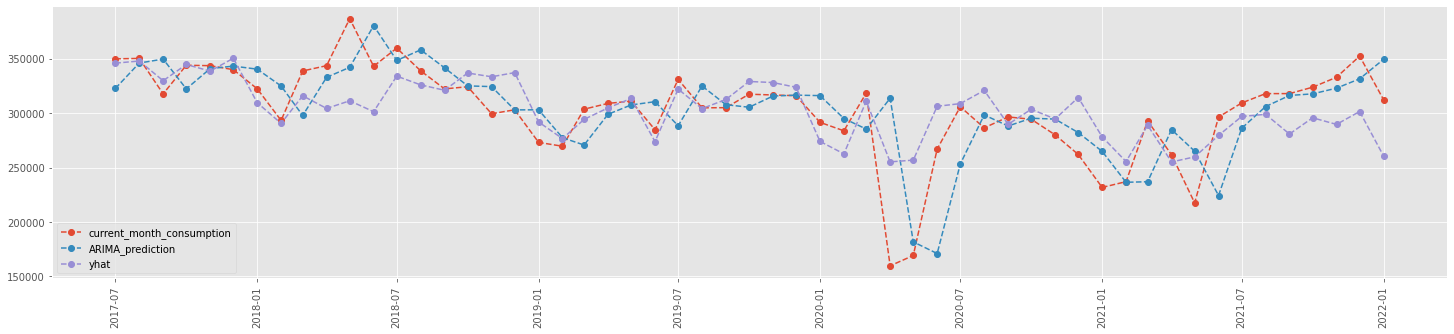

In [16]:
from src.utils.plotting import plot_metrics
plot_metrics(feature_engineered_df.query("province == 'İSTANBUL'"), col_x="date", col_y1="current_month_consumption", col_y2="ARIMA_prediction", col_y3="yhat")

In [17]:
# Save feature_engineered_df 
feature_engineered_df.to_csv("data/feature_engineered_df.csv")